# Generating Time Series of Model Results

#### Overview
In this notebook, we will work to create a timeseries from the results of the `tutorial_global_oce_latlon` experiment that we ran on Spartan.

#### Import Modules
First, import the modules required to access read data and create plots.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm

After the modules are loaded in, establish a path to the directory for this week's class:

In [2]:
# Define a path to this lesson's folder
lesson_folder = '/Users/cool/Workspace/MLML/ms274_fall2025/Lectures/Week 5/'

## Finding a point in the model grid

In this notebook, we will generate a timeseries of the model output. However, if we would like to select a specific point on the globe, we will need to have a definition of the model grid. These components can be determined in two ways. First, if the model grid is defined in polar coordinates, the grid can be reconstructed based on the information in the data file. Fill in following information based on the contents of the data file.

In [3]:
delX = 4
delY = 4
xgOrigin = 0
ygOrigin = -80
n_rows = 40
n_cols = 90 

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)

When defined in this fashion, the XC and YC grids of the model correspond to the longitude and latitude of the grid center points. Make a plot of the longitude and latitude here:

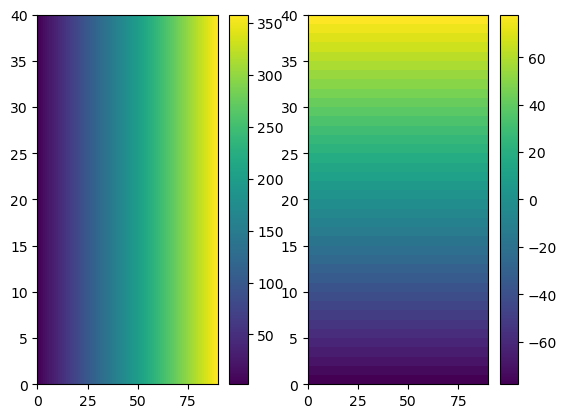

In [4]:
# make a side by side plot of the XC and YC fields
plt.subplot(1,2,1)
plt.pcolormesh(XC)
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(YC)
plt.colorbar()

When starting a model from `nIter=0` as we did here, the model will also output the `XC` and `YC` fields for reference. Read those fields here and ensure they look the same as above:

In [5]:
# read in the XC and YC fields
XC_file = os.path.join(lesson_folder, 'run', 'XC.data')
XC = np.fromfile(XC_file, '>f4').reshape(40, 90)

YC_file = os.path.join(lesson_folder, 'run', 'YC.data')
YC = np.fromfile(YC_file, '>f4').reshape(40, 90)

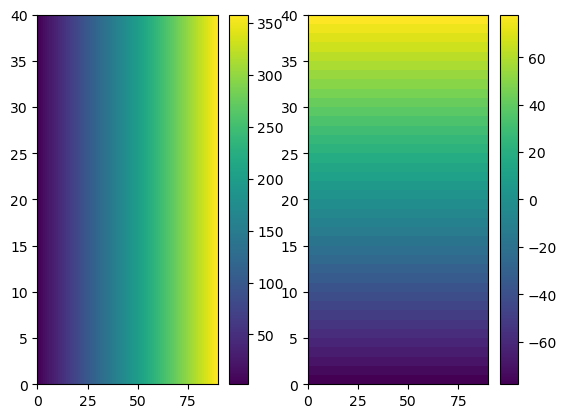

In [6]:
# remake a side by side plot of the XC and YC fields
plt.subplot(1,2,1)
plt.pcolormesh(XC)
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(YC)
plt.colorbar()

When working with model output, its always a good idea to work with the grid as the model knows it rather than re-creating the model grid on your own. Often times, there are rounding errors and other small subtlies that will create differences in the grids.

## Make a timeseries
Next we'll explore how the model is evolving through time. For this example, I'll choose a point in the Gulf Stream and and I'll plot that on a map to ensure it's in the right location. 

In [19]:
# define the lon/lat point
lon = 291
lat = 37

# find its location in the grid
dist = ((XC - lon)**2 + (YC-lat)**2) **0.5
row, col = np.where(dist==np.min(dist))
print(row, col)

[29] [72]


To get the map, I will use the `Depth.data` file provided by the model:

In [ ]:
# read in the depth grid


Let's see where the point is on our plot:

In [ ]:
# make a plot of the depth with the point on top of it


When I'm happy with the location of the point, I'll loop through all of the output files to generate a timeseries:

In [17]:
# make an empty array
uvel_timeseries = np.zeros((365,))

# loop through all the files in the diags dir
for day in range(1, 366):

    # identify the data file path
    data_path = os.path.join(lesson_folder, 'run', 'diags', 'UVEL', 'UVEL.'+'{:010d}'.format(day)+'.data')
    

    # read in the data
    u_grid = np.fromfile(data_path, '>f4').reshape((40, 90))
    

    # sample the data at the point provided and store it in the array
    uvel_timeseries[day-1] = u_grid[row[0], col[0]]

Finally, I'll plot the timeseries:

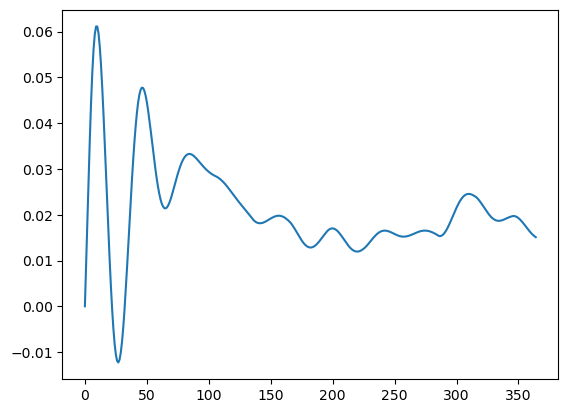

In [18]:
# plot the timeseries
plt.plot(uvel_timeseries)

Hmmm... what's going on here? The ocean is subject to a constant wind forcing, but there is a lot of variablity in the wind speed? Discuss with a neighbor.

### &#x1F914; Try it for yourself
Make timeseries for `THETA`, `SALT`, `UVEL`, `VVEL` at a point in the ocean and plot all four in a plot with four rows and one column.

In [ ]:
plot_dir = '/Users/mike/Documents/SJSU/CS_185C/Project/plots'

In [ ]:
def plot_panel(run_dir, plot_dir, file_name):

    # read in the data
    grid = np.fromfile(os.path.join(run_dir,'TS_surf_daily_mean',
                                file_name), '>f4')
    grid = grid.reshape((2,nrows,ncols))
    timestep_number = int(file_name.split('.')[-2])

    # make a figure 
    fig = plt.figure(figsize=(7,8))
    gs1 = GridSpec(11, 10, left=0.1, right=0.98, bottom=0.06, top=0.95, hspace=0.05)

    # plot the temperature
    ax1 = fig.add_subplot(gs1[:-2, :])
    C = ax1.pcolormesh(XC[:,:-1], YC[:,:-1], grid[0,:,:-1], cmap='turbo', vmin=6, vmax=22)
    plt.colorbar(C, label='Temperature ($^{\circ}$C)')

    # # plot the land in grey
    # land = (grid[0,:,:-1]==0).astype(int)
    # print(np.min(land), np.max(land))
    # land = np.ma.masked_where(land, land==0)
    # print(land)
    # ax1.pcolormesh(XC[:,:-1], YC[:,:-1], land, cmap='Greys')#, vmin=-1, vmax=1)
    
    # format the axes
    plt.title('CA Current')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')

    max_timestep_number = int(366*24*60*60/300)
    ax2 = fig.add_subplot(gs1[-1, :-2])
    rect = Rectangle((0,0),timestep_number, 1, facecolor='grey', edgecolor='k')
    ax2.add_patch(rect)
    ax2.set_xlim([0, max_timestep_number])
    ax2.set_ylim([0, 1])
    ax2.set_xticks([0,max_timestep_number])
    ax2.set_xticklabels([2008,2009])
    ax2.set_yticklabels([])
    ax2.set_xlabel('Time')
    
    output_file = os.path.join(plot_dir,'panels',file_name[:-5]+'.png')
    plt.savefig(output_file, facecolor='white')
    plt.close(fig)


# test the function
plot_panel(run_dir, plot_dir, 'TS_surf_daily_mean.0000016992.data')
plot_panel(run_dir, plot_dir, 'TS_surf_daily_mean.0000068256.data')

When we're happy with the plotting function, we can use it to make the panels:

In [ ]:
for file_name in sorted(os.listdir(os.path.join(run_dir,'TS_surf_daily_mean'))):
    if file_name[-4:]=='data':
        plot_panel(run_dir, plot_dir, file_name)

And then stitch everything together into a movie:

In [ ]:
panel_list = []
for file_name in sorted(os.listdir(os.path.join(plot_dir,'panels'))):
    if file_name[-4:]=='.png':
        panel_list.append(os.path.join(plot_dir,'panels',file_name))

In [ ]:
# set the frames per second
fps=5

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(panel_list, fps=fps)

# write the video to a file
clip.write_videofile(os.path.join(plot_dir,'CA Sea Surface Temperature.mp4'))

This is just a first analysis with my first model run. Next, I will wotk to run my next model experiment and analyze the comparison.

If there's time: This 